<a href="https://colab.research.google.com/github/ibonetc/DeepLearning_Salud/blob/main/Autoencoder_MedicalExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder convolucional

Un autoencoder es un algoritmo para compresión y descompresión de datos, con la paticularidad es capaz de reprodicir sólo datos similares a los que aprende. Lo más común es verlo como una red neuronal convolucional.

Se divide en dos componentes:

*   Encoder: Es el módulo encargado de comprimir los datos a un espacio latente
*   Decoder: Es el módulo encargado de descomprimir los datos, tratando de reconstruir la entrada original.


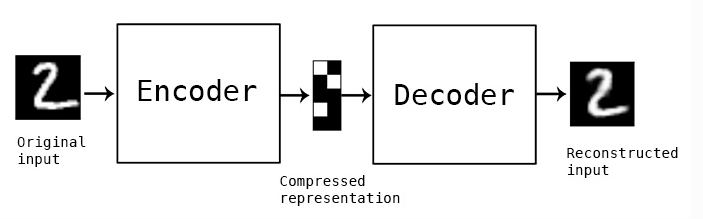
 
Tomada de: [Blog Keras](https://blog.keras.io/building-autoencoders-in-keras.html)


Los codificadores automáticos tienen pérdidas, lo que significa que las salidas descomprimidas se degradarán en comparación con las entradas originales.

En este ejemplo vamos a usar la base de datos MNIST para demostrar el uso de eliminación de ruido.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist,fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Flatten, Dense, Reshape,Conv2D,MaxPooling2D,Conv2DTranspose

## Cargando los datos
- Acá cada imagen tiene un tamaño de 28x28, lo que significa una entrada de 784

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()

# Normalizar los datos
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

print (x_train.shape)
print (x_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


### Reshape

Adicionar la tercera dimensión de la imagen (En las imágenes a color no es necesario hacer esto).

train_data= np.reshape(x_train, (len(x_train), 28, 28, 1))
test_data= np.reshape(x_test, (len(x_test), 28, 28, 1))

Otra opción de Reshape

train_data = x_train[..., tf.newaxis]
test_data = x_test[..., tf.newaxis]

In [ ]:
train_data= np.reshape(x_train, (len(x_train), 28, 28, 1))
test_data= np.reshape(x_test, (len(x_test), 28, 28, 1))
print (train_data.shape)
print (test_data.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## Ejemplo de eliminación de ruido

Para esto, vamos a crear unas imágenes con ruido a partir de las originales, para probar que el modelo sea capaz de reconstruir la imagen.

Se creará un encoder que comprima la imagen de una dimensión de 784 a 32 y un módulo decoder que la vuelva a **reconstruir**

### Crear imágenes con ruido

In [ ]:
noisy_array = train_data + 0.7 * np.random.normal(loc=0.0, scale=1.0, size=train_data.shape)
noisy_train_data=np.clip(noisy_array, 0.0, 1.0)

In [ ]:
noisy_array = test_data + 0.7 * np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)
noisy_test_data=np.clip(noisy_array, 0.0, 1.0)

Mostrar primeras 10 imágenes, comparadas con las generadas con ruido

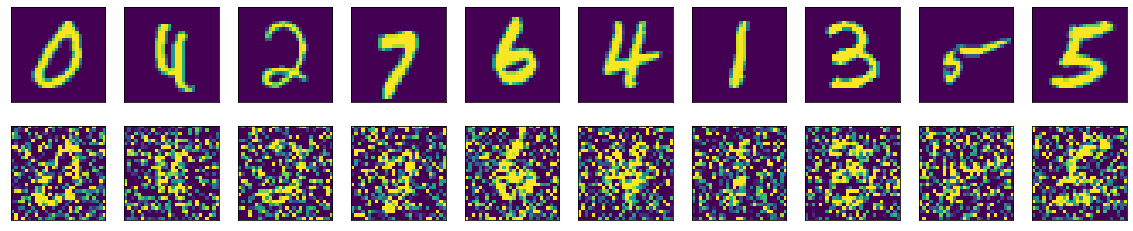

In [ ]:
indices = np.random.randint(len(train_data), size=10)
images1 = train_data[indices, :]
images2 = noisy_train_data[indices, :]
plt.figure(figsize=(20, 4))
for i, (images1, images2) in enumerate(zip(images1, images2)):
  ax = plt.subplot(2, 10, i + 1)
  plt.imshow(images1.reshape(28, 28),)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(2, 10, i + 1 + 10)
  plt.imshow(images2.reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

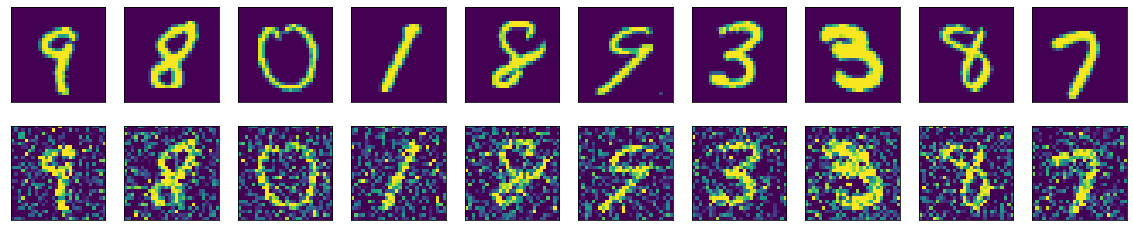

In [ ]:
indices = np.random.randint(len(test_data), size=10)
images1 = test_data[indices, :]
images2 = noisy_test_data[indices, :]
plt.figure(figsize=(20, 4))
for i, (images1, images2) in enumerate(zip(images1, images2)):
  ax = plt.subplot(2, 10, i + 1)
  plt.imshow(images1.reshape(28, 28),)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(2, 10, i + 1 + 10)
  plt.imshow(images2.reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

### Ejemplo de modelo autoencoder

In [ ]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
encoder = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
encoder = layers.MaxPooling2D((2, 2), padding="same")(encoder)
encoder = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(encoder)
encoder = layers.MaxPooling2D((2, 2), padding="same")(encoder)

# Decoder
decoder = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoder)
decoder = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(decoder)
decoder = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(decoder)

# Autoencoder
autoencoder = Model(input, decoder)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        9248  

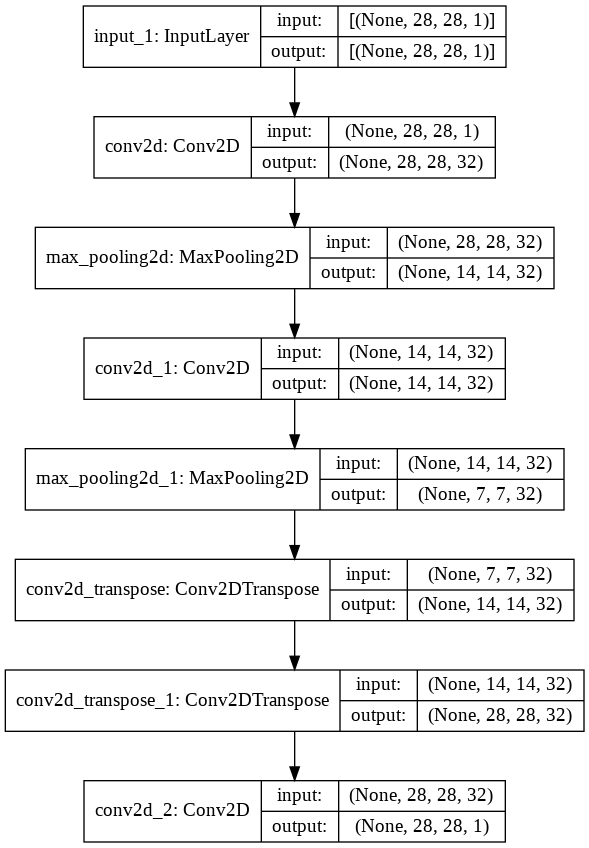

In [ ]:
tf.keras.utils.plot_model(autoencoder,show_shapes=True,show_layer_names=True)

In [ ]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/50
469/469 [==============================] - 4s 9ms/step - loss: 0.1000 - val_loss: 0.0929
Epoch 2/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0925 - val_loss: 0.0909
Epoch 3/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0909 - val_loss: 0.0897
Epoch 4/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0899 - val_loss: 0.0892
Epoch 5/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0892 - val_loss: 0.0882
Epoch 6/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0887 - val_loss: 0.0877
Epoch 7/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0882 - val_loss: 0.0875
Epoch 8/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0879 - val_loss: 0.0877
Epoch 9/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0876 - val_loss: 0.0867
Epoch 10/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0873 - val_loss: 0.0869

In [ ]:
predictions = autoencoder.predict(noisy_test_data)

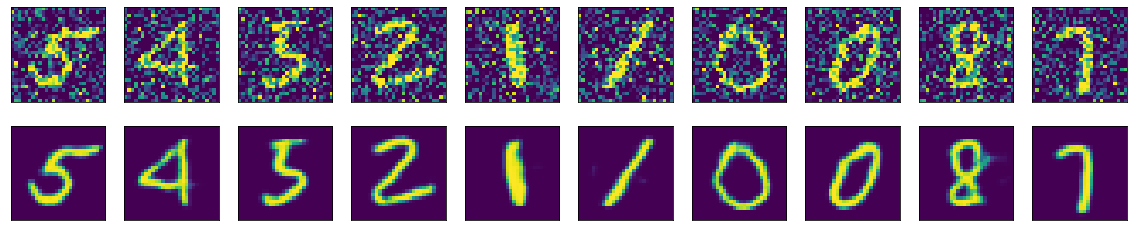

In [ ]:
indices = np.random.randint(len(noisy_test_data), size=10)
images1 = noisy_test_data[indices, :]
images2 = predictions[indices, :]
plt.figure(figsize=(20, 4)) 
for i, (images1, images2) in enumerate(zip(images1, images2)):
  ax = plt.subplot(2, 10, i + 1)
  plt.imshow(images1.reshape(28, 28),)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(2, 10, i + 1 + 10)
  plt.imshow(images2.reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

## Ejercicio
Haga un autoencoder para detectar ruido en imágenes médicas.
Utilice la base de datos MNISTMedicalImages para esto.
Pruebe diferentes topologías y niveles de ruido.

## Ejemplo de detección de anomalías

Para esto utilizaremos un ejemplo [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). Esta base de datos tiene 5000 electrocardiogramas, donde cada uno tiene 140 puntos. Los casos están etiquetados, donde 0 significa ritmo no normal y 1 ritmo normal.

La idea es poder identificar los ritmos con anomalías (no normales).

Este ejemplo, al ser supervisado se puede tratar con cualquier método de clasificación. Aquí la idea es mostrar un ejemplo donde, partiendo de un modelo que se entrene con casos de ritmo normal, sea capaz de identificar cuando no es normal.

Recuerde que una **Serie de tiempo** es una sucesión de datos medidos en intervalos de tiempo (regulares o no) y ordenados cronológicamente.

### Cargar los datos

In [ ]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

Como se puede ver la columna 140 tiene la etiqueta, y de la 0 a la 139 están los puntos de la señal del electrocardiograma.

In [ ]:
labels = raw_data[:, -1]
data = raw_data[:, 0:-1]
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2,stratify=labels)

In [ ]:
print(np.unique(train_labels,return_counts=True))
print(np.unique(test_labels,return_counts=True))

(array([0., 1.]), array([1663, 2335]))
(array([0., 1.]), array([416, 584]))


### Normalizar los datos

In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

### Preparar los datos

Como vamos a entrenar el modelo sólo con los datos normales, entonces vamos a separar los que la etiqueta es 1 (label=1)

In [ ]:
train_labels

array([1., 1., 1., ..., 0., 1., 1.])

In [ ]:
train_labels==1

array([ True,  True,  True, ..., False,  True,  True])

In [ ]:
one_train_labels=train_labels==1
one_test_labels=test_labels==1

In [ ]:
normal_train_data = train_data[one_train_labels]
normal_test_data = test_data[one_test_labels]

anomalous_train_data = train_data[~one_train_labels]
anomalous_test_data = test_data[~one_test_labels]

Ejemplo de una señal normal y otra con anomalía

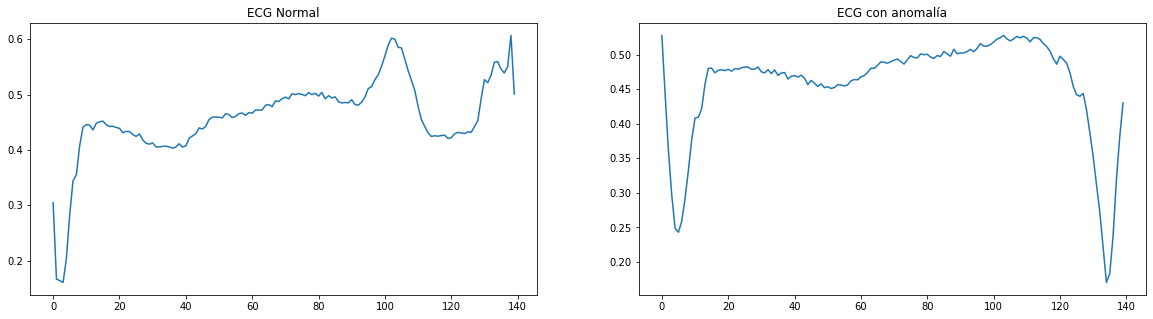

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(140), normal_train_data[0])
plt.title("ECG Normal")
plt.subplot(1, 2, 2)
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("ECG con anomalía")
plt.show()

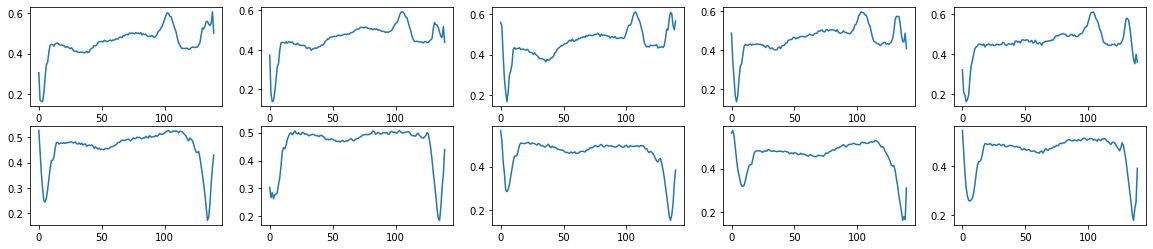

In [ ]:
n=5
plt.figure(figsize=(20, 4))
for i, (s1, s2) in enumerate(zip(normal_train_data[0:n], anomalous_train_data[0:n])):
  ax = plt.subplot(2, n, i + 1)
  plt.plot(np.arange(140), s1)
  ax = plt.subplot(2, n, i + 1 + n)
  plt.plot(np.arange(140), s2)
plt.show()

In [ ]:
input= Input(shape=(140,))
encoder = Dense(32, activation="relu")(input)
encoder = Dense(16, activation="relu")(encoder)

encoder = Dense(8, activation="relu")(encoder)
    
decoder = Dense(16, activation="relu")(encoder)
decoder = Dense(32, activation="relu")(decoder)

decoder = Dense(140, activation="sigmoid")(decoder)

autoencoder=Model(input, decoder)

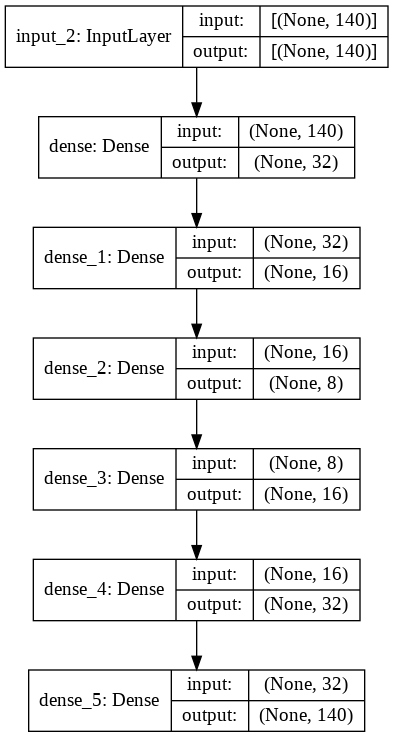

In [ ]:
tf.keras.utils.plot_model(autoencoder,show_layer_names=True,show_shapes=True)

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=50, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/50
5/5 [==============================] - 3s 40ms/step - loss: 0.0582 - val_loss: 0.0537
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0570 - val_loss: 0.0527
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0556 - val_loss: 0.0515
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0535 - val_loss: 0.0500
Epoch 5/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0504 - val_loss: 0.0487
Epoch 6/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0469 - val_loss: 0.0466
Epoch 7/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0432 - val_loss: 0.0444
Epoch 8/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0397 - val_loss: 0.0427
Epoch 9/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0364 - val_loss: 0.0411
Epoch 10/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0335 - val_loss: 0.0396
Epoch 11/50
5/5 [=====================

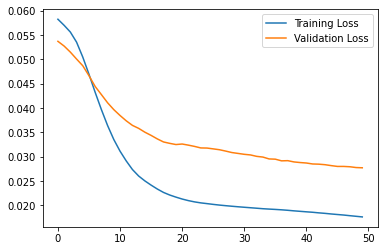

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

Plot de una señal sin anomalía y una con anomalías

Ejemplo de señal normal:

In [ ]:
reconstructions = autoencoder(test_data)

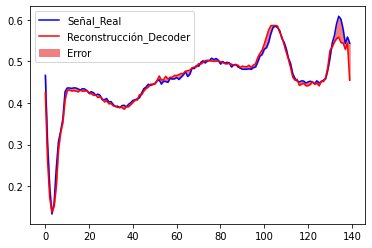

In [ ]:
plt.plot(normal_test_data[0], 'b')
plt.plot(reconstructions[0], 'r')
plt.fill_between(np.arange(140), reconstructions[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Señal_Real", "Reconstrucción_Decoder", "Error"])
plt.show()

Ejemplo de señal con anomalía

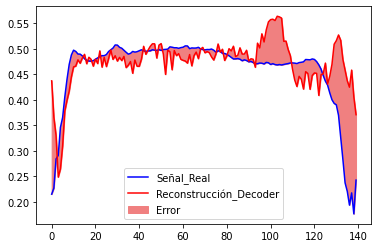

In [ ]:
reconstructions = autoencoder(anomalous_test_data)
plt.plot(anomalous_test_data[0], 'b')
plt.plot(reconstructions[0], 'r')
plt.fill_between(np.arange(140), reconstructions[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Señal_Real", "Reconstrucción_Decoder", "Error"])
plt.show()

### Dectección de anomalías


Para la detección de anomalía vamos a usar el error de la reconstrucción. Para esto podemos usar un umbral, que pudiera ser el error medio promedio para los ejemplos que tienen ritmo normal, con cierta desviación estándar. 

Podemos estimar que la señal tiene anomalía si el error de reconstrucción de una señal está está por encima de ese umbral.


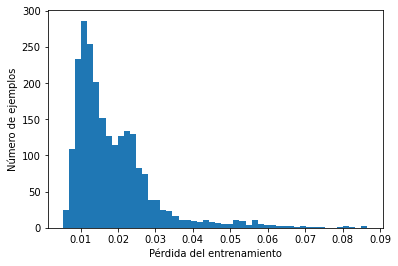

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel('Pérdida del entrenamiento')
plt.ylabel('Número de ejemplos')
plt.show()

Usando como umbral la media de la pérdida más la desviación estándar.

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Umbral: ", threshold)

Umbral:  0.02981475


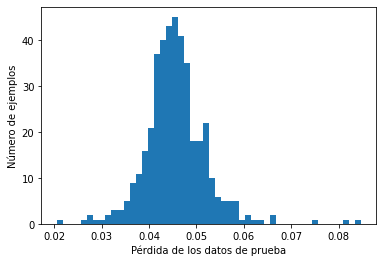

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Pérdida de los datos de prueba")
plt.ylabel("Número de ejemplos")
plt.show()

In [ ]:
# Predecir 
reconstructions = autoencoder(test_data)
loss = tf.keras.losses.mae(reconstructions, test_data)
predictions= tf.math.less(loss, threshold)

In [ ]:
print("Accuracy = {}".format(accuracy_score(test_labels, predictions)))
print("Precision = {}".format(precision_score(test_labels, predictions)))
print("Recall = {}".format(recall_score(test_labels, predictions)))

Accuracy = 0.934
Precision = 0.990530303030303
Recall = 0.8955479452054794
